In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [133]:
df= pd.read_pickle('/content/drive/MyDrive/data_prep2.txt')

In [134]:
df.head()

,Review,Rating,Sentiment,char_count,Word_count,Average_Word_Length,Clean,Review_lists,polarity,text_blob_sent,scores,compound,neg,pos
0,nice hotel expensive parking got good deal sta...,4,1,593,87,6.816092,nice hotel expensive parking got good deal sta...,"[nice, hotel, expensive, parking, got, good, d...",0.208744,1,"{'neg': 0.072, 'neu': 0.643, 'pos': 0.285, 'co...",0.9747,0.072,0.285
1,ok nothing special charge diamond member hilto...,2,0,1689,250,6.756000,ok nothing special charge diamond member hilto...,"[ok, nothing, special, charge, diamond, member...",0.214923,1,"{'neg': 0.11, 'neu': 0.701, 'pos': 0.189, 'com...",0.9787,0.110,0.189
2,nice rooms not 4* experience hotel monaco seat...,3,0,1427,217,6.576037,nice rooms 4 experience hotel monaco seattle g...,"[nice, rooms, 4, experience, hotel, monaco, se...",0.294420,1,"{'neg': 0.081, 'neu': 0.7, 'pos': 0.219, 'comp...",0.9889,0.081,0.219
3,"unique, great stay, wonderful time hotel monac...",5,1,600,89,6.741573,unique great stay wonderful time hotel monaco ...,"[unique, great, stay, wonderful, time, hotel, ...",0.504825,1,"{'neg': 0.06, 'neu': 0.555, 'pos': 0.385, 'com...",0.9912,0.060,0.385
4,"great stay great stay, went seahawk game aweso...",5,1,1281,191,6.706806,great stay great stay went seahawk game awesom...,"[great, stay, great, stay, went, seahawk, game...",0.384615,1,"{'neg': 0.135, 'neu': 0.643, 'pos': 0.221, 'co...",0.9797,0.135,0.221


In [5]:
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud,STOPWORDS
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download(['punkt', 'wordnet', 'omw-1.4', 'stopwords'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Lemmatisation des données**

In [6]:
#text prerocessing
def text_preprocess(text):
    """
    Tokenize 
    Input: Raw text
           
    Output: Lemmatized texts
    """

    text = re.sub(r'https?://\S+', '', text) #remove http links
    text = re.sub(r"[^a-zA-Z]", " ", text) #remove punktuation and numbers
    
    tokens = word_tokenize(text) #tokenize to words

    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words("english")

    clean_tokens = [lemmatizer.lemmatize(tok).lower().strip() for tok in tokens if tok not in stop_words] #lematization and stop words removal
    
    return ' '.join(clean_tokens)

In [7]:
X_clean = df['Review'].apply(text_preprocess)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix , f1_score, roc_auc_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

**Choix de la méthodologie de séparation des données**

**1. train_test_split**

In [18]:
index = 0
y_sent= df['Sentiment']
y_rate=df['Rating']

#split data
X_train, X_test, y_train, y_test = train_test_split(X_clean.values, y_sent.values, test_size = 0.2, stratify = y_sent, random_state = 10)

#define empty DataFrame for results
df_results = pd.DataFrame(columns = ['model', 'f1_pos', 'f1_neg', 'roc_auc'])


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix


In [12]:
list_model=[LogisticRegression(max_iter=1000), DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier()]

In [46]:
def train_models(list_model):
  for idx, name in enumerate(list_model):

    print(f'Training model {name} ...')
    clf= Pipeline([ ('vec', TfidfVectorizer()), ('clf', list_model[idx])])
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    
    #calculate metrics
    f1_fold = f1_score(y_test,y_hat)
    f1_neg_fold = f1_score(y_test,y_hat, pos_label = 0)
    cr_fold = classification_report(y_test,y_hat)
    roc_fold = roc_auc_score(y_test,y_hat)

    #write results
    df_results.loc[index, 'model'] = name
    df_results.loc[index, 'f1_pos'] = f1_fold
    df_results.loc[index, 'f1_neg'] = f1_neg_fold
    df_results.loc[index, 'roc_auc'] = roc_fold

    

In [42]:
train_models(list_model)

Training model LogisticRegression(max_iter=1000) ...
Training model DecisionTreeClassifier() ...
Training model RandomForestClassifier() ...
Training model KNeighborsClassifier() ...


In [43]:
display(df_results)

,model,f1_pos,f1_neg,roc_auc
0,LogisticRegression(max_iter=1000),0.93533,0.788542,0.836717
1,DecisionTreeClassifier(),0.856108,0.588512,0.719958
2,"(DecisionTreeClassifier(max_features='auto', r...",0.900839,0.565046,0.697087
3,KNeighborsClassifier(),0.879819,0.497789,0.664355
4,KNeighborsClassifier(),0.874315,0.492005,0.661005


**2. Kfold cross validation**

Cette méthode nous permet de palier aux variations de l'échantillon pris mais nous permet aussi d'avoir en sortie les métriques dont on a besoin.

In [59]:
tvec = TfidfVectorizer(stop_words=None)
lr = LogisticRegression(max_iter=1000)

In [66]:
def lr_cv(X, Y, model, average_method='binary'):
    model_linear = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=None)),
    ('classifier', model)
])
    cv_results = cross_validate(model_linear, X, Y,cv=5)
    cv_results = pd.DataFrame(cv_results)
    return cv_results

In [60]:
lr_cv(X_clean, y_sent, lr)

training model LogisticRegression(max_iter=1000)


,fit_time,score_time,test_score
0,4.332628,0.442559,0.892169
1,3.689055,0.410654,0.898487
2,4.494107,0.345574,0.889458
3,3.198734,0.397680,0.896535
4,4.679940,0.458359,0.894827


Nous remarquons que les résultats sont bons et homogène sur les 5 différents split

**3- Comparaison avec un classifieur Random**

In [61]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(X_train, y_train)

DummyClassifier(random_state=0, strategy='most_frequent')

In [65]:
clf.score(X_test,y_test)

0.7365211027079775

Nous remarquons que le résultat du dummy classifier est bon , en prenant en compte la classe majoritaire , mais il reste moins bon que la regression logistique , qui ne s'effectue pas au random.

**Fonction d'aide qui sert d'antrainer les modèles**

In [85]:
def lmodel_cv(liste, X, Y, vectorizer=tvec,average_method='binary'):
  for model in liste:
    pipe = Pipeline([
                  ('tfidf', vectorizer),
                  ('classify', model)
                ])
    cv_results = cross_validate(pipe, X, Y,cv=5)
    res = pd.DataFrame(cv_results)
    print("Accuracy du modèle "f"{model} :"
        f"{res['test_score'].mean():.3f} +/- {res['test_score'].std():.3f}\n"
        f"{res['fit_time'].mean()}"
      )

**2- Résultats sur différents scénarios**

**Résultats de différents modèles de classification binaire avec les critiques nettoyées et lemmatisées**

In [76]:
lmodel_cv(list_model, X_clean,y_sent)

Accuracy du modèle LogisticRegression(max_iter=1000) :0.894 +/- 0.004
4.656058645248413
Accuracy du modèle DecisionTreeClassifier() :0.780 +/- 0.009
20.428652906417845
Accuracy du modèle RandomForestClassifier() :0.840 +/- 0.013
27.52852358818054
Accuracy du modèle KNeighborsClassifier() :0.785 +/- 0.023
1.4950197696685792


**Résultats de différents modèles de classification binaire avec les critiques brutes**

In [77]:
lmodel_cv(list_model, df.Review,y_sent)

Accuracy du modèle LogisticRegression(max_iter=1000) :0.898 +/- 0.004
4.08646788597107
Accuracy du modèle DecisionTreeClassifier() :0.779 +/- 0.011
19.616008901596068
Accuracy du modèle RandomForestClassifier() :0.839 +/- 0.012
30.020052671432495
Accuracy du modèle KNeighborsClassifier() :0.791 +/- 0.020
1.7198577404022217


**Résultats de différents modèles de classification multiclasses**

In [78]:
lmodel_cv(list_model, df.Review,y_rate,average_method='macro')

Accuracy du modèle LogisticRegression(max_iter=1000) :0.609 +/- 0.007
30.760605669021608
Accuracy du modèle DecisionTreeClassifier() :0.443 +/- 0.006
26.716736030578613
Accuracy du modèle RandomForestClassifier() :0.519 +/- 0.008
51.12527294158936
Accuracy du modèle KNeighborsClassifier() :0.450 +/- 0.023
1.7151855945587158


Les résultats sont toujours meilleurs avec la regression linéaire suivie de random forest

Nous constatons aussi des résultats médiocres en terme de classification par rating (multiclass classification (0.6)

Concernant la classification binaire , les résultats sont très bon mais allons voire plus loin la matrice de confusion .

**Résultats de différents modèles avec une accuracy équilibrée**

In [88]:
def lr_cv_balanced(X, Y, model):
    model_linear = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=None)),
    ('classifier', model)
])
    cv_results = cross_validate(model_linear, X, Y,cv=5, scoring="balanced_accuracy")
    cv_results = pd.DataFrame(cv_results)
    return cv_results

In [90]:
lr_cv_balanced(df.Review, y_sent, lr)

,fit_time,score_time,test_score
0,4.320276,0.498291,0.853293
1,4.585388,0.457637,0.843693
2,3.672983,0.380662,0.835118
3,4.244349,0.459207,0.841240
4,4.144080,0.535722,0.828306


Nous remarequons que l'accuracy générale reste bonne


**Matrice de confusion de la regression logistique**

In [91]:
REG_LIN = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=None)),
    ('classifier', lr)
])

**1. Classification binaire**

In [92]:
CONF_MAT= confusion_matrix(cross_val_predict(REG_LIN, df.Review, y_sent, cv=5), y_sent)

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [104]:
# fonction qui permet la visualisation de la matrice de confusion
def draw_mat(conf_mat,n,names=["negative", "positive"]):
  matrice_proportions = np.zeros((n,n))
  for i in range(0,n):
      matrice_proportions[i,:] = conf_mat[i,:]/float(conf_mat[i,:].sum())
  confusion_df = pd.DataFrame(matrice_proportions, index=names,columns=names)
  plt.figure(figsize=(5,5))
  sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
  plt.ylabel(r'Valeur réelle',fontsize=14)
  plt.xlabel(r'Valeur prédite',fontsize=14)
  plt.tick_params(labelsize=12)

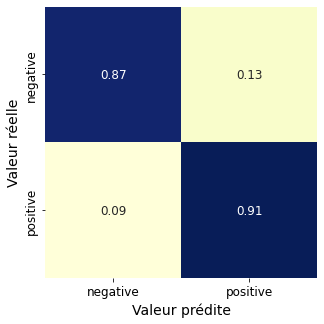

In [106]:
draw_mat(CONF_MAT,2)

Nous remarquons que les résultats sont bons en général, mais que la classe positive majoritaire a de meilleurs résultats .

**2. Classification multiclasse**

In [100]:
CONF_MAT2= confusion_matrix(cross_val_predict(REG_LIN, df.Review, y_rate, cv=5), y_rate)

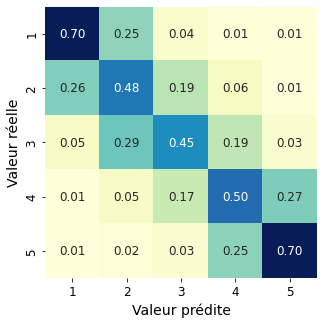

In [107]:
draw_mat(CONF_MAT2,5,["1", "2","3","4","5"])

Nous remarequons que les prédictions des classes intémédiaires sont vraiment mauvaises comparées à celle des notes extrêmes qui restent correctes

**Utilisation des autres features**

In [123]:
X_features= df.drop(['Rating', 'Sentiment','Clean', 'Review_lists', 'text_blob_sent', 'polarity'], axis=1)

In [110]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# pipeline for numerical data
numerical_features=["char_count", "Word_count", "Average_Word_Length"]

# initialise model and vectorizers
stand = MinMaxScaler()

# construct the column transfomer
column_transformer = ColumnTransformer(
    [('tfidf', tvec, 'Review'), 
    ('standard', stand, numerical_features)],
    remainder='passthrough')

**1. avec les features numériques et review**

In [124]:
lmodel_cv(list_model, X_features,y_sent, vectorizer=column_transformer)

Accuracy du modèle LogisticRegression(max_iter=1000) :0.898 +/- 0.004
5.578087711334229
Accuracy du modèle DecisionTreeClassifier() :0.779 +/- 0.008
23.599179840087892
Accuracy du modèle RandomForestClassifier() :0.838 +/- 0.012
30.49045033454895
Accuracy du modèle KNeighborsClassifier() :0.796 +/- 0.020
1.998577356338501


**2. en ajoutant sentiment de textblob**

In [119]:
X_features= df.drop(['Rating', 'Sentiment','Clean', 'Review_lists', 'polarity'], axis=1)
# pipeline for numerical data
numerical_features=["char_count", "Word_count", "Average_Word_Length",'text_blob_sent']

In [120]:
lmodel_cv(list_model, X_features,y_sent, vectorizer=column_transformer)

Accuracy du modèle LogisticRegression(max_iter=1000) :0.895 +/- 0.004
6.194616365432739
Accuracy du modèle DecisionTreeClassifier() :0.790 +/- 0.012
21.604042196273802
Accuracy du modèle RandomForestClassifier() :0.844 +/- 0.010
28.851219177246094
Accuracy du modèle KNeighborsClassifier() :0.813 +/- 0.017
2.2243819713592528


**3. en ajoutant sentiment de polarity**

In [125]:
X_features= df.drop(['Rating', 'Sentiment','Clean', 'Review_lists', 'text_blob_sent'], axis=1)
# pipeline for numerical data
numerical_features=["char_count", "Word_count", "Average_Word_Length",'polarity']

In [126]:
lmodel_cv(list_model, X_features,y_sent, vectorizer=column_transformer)

Accuracy du modèle LogisticRegression(max_iter=1000) :0.897 +/- 0.002
4.752997732162475
Accuracy du modèle DecisionTreeClassifier() :0.812 +/- 0.008
24.048458862304688
Accuracy du modèle RandomForestClassifier() :0.860 +/- 0.008
27.454284954071046
Accuracy du modèle KNeighborsClassifier() :0.836 +/- 0.016
1.9267587661743164


**4. en ne normalisant pas polarity**

In [131]:
numerical_features=["char_count", "Word_count", "Average_Word_Length"]

In [132]:
lmodel_cv(list_model, X_features,y_sent, vectorizer=column_transformer)

Accuracy du modèle LogisticRegression(max_iter=1000) :0.897 +/- 0.002
3.763304615020752
Accuracy du modèle DecisionTreeClassifier() :0.815 +/- 0.007
24.78030571937561
Accuracy du modèle RandomForestClassifier() :0.858 +/- 0.008
29.05356454849243
Accuracy du modèle KNeighborsClassifier() :0.836 +/- 0.016
1.9001923084259034


**5.Rajouter vader pos, neg**

In [159]:
X_features= df.drop(['Rating', 'Sentiment','Clean', 'Review_lists', 'text_blob_sent', 'scores', 'compound'], axis=1)
# pipeline for numerical data
numerical_features=["char_count", "Word_count", "Average_Word_Length"]

In [136]:
lmodel_cv(list_model, X_features,y_sent, vectorizer=column_transformer)

Accuracy du modèle LogisticRegression(max_iter=1000) :0.901 +/- 0.004
4.247283887863159
Accuracy du modèle DecisionTreeClassifier() :0.818 +/- 0.005
24.712559175491332
Accuracy du modèle RandomForestClassifier() :0.873 +/- 0.007
27.992662525177003
Accuracy du modèle KNeighborsClassifier() :0.844 +/- 0.013
2.6549437046051025


In [161]:
pipe_lr = Pipeline([
                  ('tfidf', column_transformer),
                  ('classify', lr)
                ])

In [162]:
CONF_MAT3= confusion_matrix(cross_val_predict(pipe_lr, X_features, y_sent, cv=5), y_sent)

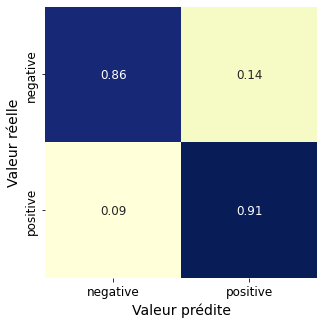

In [163]:
draw_mat(CONF_MAT3,2)

In [160]:
lmodel_cv(list_model, X_features,y_rate, vectorizer=column_transformer)

Accuracy du modèle LogisticRegression(max_iter=1000) :0.618 +/- 0.008
37.5728837966919
Accuracy du modèle DecisionTreeClassifier() :0.478 +/- 0.008
27.62311987876892
Accuracy du modèle RandomForestClassifier() :0.553 +/- 0.007
52.08436288833618
Accuracy du modèle KNeighborsClassifier() :0.485 +/- 0.015
1.9379139423370362


In [164]:
CONF_MAT4= confusion_matrix(cross_val_predict(pipe_lr, X_features, y_rate, cv=5), y_rate)

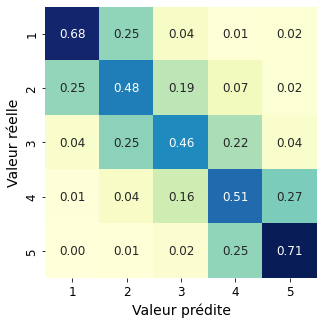

In [166]:
draw_mat(CONF_MAT4,5,["1", "2","3","4","5"])

**6. en ajoutant compound**

In [142]:
X_features= df.drop(['Rating', 'Sentiment','Clean', 'Review_lists', 'text_blob_sent', 'scores'], axis=1)
numerical_features=["char_count", "Word_count", "Average_Word_Length"]

In [143]:
lmodel_cv(list_model, X_features,y_sent, vectorizer=column_transformer)

Accuracy du modèle LogisticRegression(max_iter=1000) :0.899 +/- 0.004
4.858785581588745
Accuracy du modèle DecisionTreeClassifier() :0.815 +/- 0.006
24.841310214996337
Accuracy du modèle RandomForestClassifier() :0.873 +/- 0.008
27.736583518981934
Accuracy du modèle KNeighborsClassifier() :0.851 +/- 0.011
1.9065592288970947


**Utilisation du wordembedding avec le meilleur modèle** 

In [144]:
!pip install gensim==4.0
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.9 MB 1.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 4.8 MB/s 
     |████████████████████████████████| 2.2 MB 45.6 MB/s 


In [145]:
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
import numpy as np
     

In [146]:
def encode(msg, model, dim):
    return np.mean([model[word] for word in msg if word in model] or [np.zeros(dim)], axis = 0)
     

In [147]:
# Feed a word2vec with the ingredients
model_w2v = Word2Vec(df.Review_lists, vector_size=300, window=5, min_count=2, workers=8, sg=1)

In [148]:
wv=model_w2v.wv
wv.save("reviews")

In [149]:
w2v = KeyedVectors.load('reviews')

In [150]:
w2v.similar_by_word("hotel")

[('hoteloverall', 0.7327694296836853),
 ('sumner', 0.7262856960296631),
 ('hotelit', 0.7245540022850037),
 ('alba', 0.7163860201835632),
 ('hotelthe', 0.7159533500671387),
 ('zandbergen', 0.7151482105255127),
 ('icaria', 0.7137971520423889),
 ('well-priced', 0.708467960357666),
 ('principal', 0.7083016037940979),
 ('apex', 0.7073767781257629)]

In [151]:
X_w2v = np.array([encode(msg, w2v, 300) for msg in df.Review_lists])

In [152]:
X_w2v.shape

(20491, 300)

**Application des modèles**

In [153]:
model_lr = Pipeline([                                   
    ('classifier', LogisticRegression(random_state=42, max_iter= 10000))
])

In [154]:
cv_results = cross_validate(model_lr, X_w2v, y_sent, cv=5)
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_score
0,1.393720,0.009038,0.890217
1,1.132179,0.007171,0.894339
2,1.399231,0.007305,0.883846
3,1.334207,0.007121,0.895071
4,2.335913,0.035113,0.890190


Nous remarequons que les résultats sur la régression linaire par l'effet de l'encodage ne sont pas améliorés

In [156]:
def lr_cv_embedding(X, Y, liste,average_method='binary'):
  for model in liste:
    cv_results = cross_validate(model, X, Y,cv=5)
    res = pd.DataFrame(cv_results)
    print("Accuracy du modèle "f"{model} :"
        f"{res['test_score'].mean():.3f} +/- {res['test_score'].std():.3f}"
      )

In [ ]:
lr_cv_embedding(X_w2v, y_sent, list_model)

Accuracy du modèle LogisticRegression(max_iter=1000) :0.891 +/- 0.006
Accuracy du modèle DecisionTreeClassifier() :0.796 +/- 0.011
Accuracy du modèle RandomForestClassifier() :0.873 +/- 0.003
Accuracy du modèle KNeighborsClassifier() :0.844 +/- 0.004


In [171]:
CONF_MAT_embed= confusion_matrix(cross_val_predict(lr, X_w2v, y_sent, cv=5), y_sent)

Nous remarequons une bonne amélioration des autre modèles mis à part celui de la régression linaire

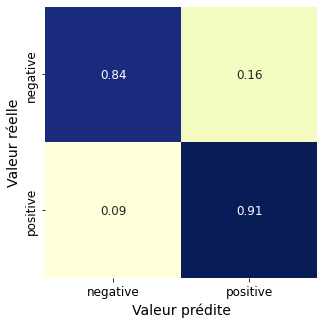

In [172]:
draw_mat(CONF_MAT_embed,2)

In [158]:
lr_cv_embedding(X_w2v, y_rate, list_model)

Accuracy du modèle LogisticRegression(max_iter=1000) :0.620 +/- 0.009
Accuracy du modèle DecisionTreeClassifier() :0.460 +/- 0.010
Accuracy du modèle RandomForestClassifier() :0.577 +/- 0.010
Accuracy du modèle KNeighborsClassifier() :0.513 +/- 0.007


In [173]:
CONF_MAT_embed1= confusion_matrix(cross_val_predict(lr, X_w2v, y_rate, cv=5), y_rate)

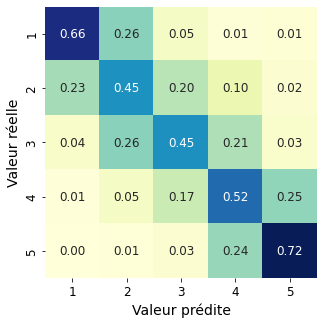

In [174]:
draw_mat(CONF_MAT_embed1,5,["1", "2","3","4","5"])

Le meilleur modèle est celui de la regression linéaire que ce soit avec tfidf vectoriser ou w2vec, le meilleur fit est celui ou on ajoute des featuresz d'analyse de sentiment (vader et textblob). Nous allons donc essayer de performer ce modèle avec les techniques de detection d'anomalies .

In [178]:
RG = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=None)),
    ('classifier', LogisticRegression())
])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.Review, y_sent, test_size=0.2, random_state=0)

In [ ]:
RG.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression())])

In [ ]:
RG.predict(X_test)

In [ ]:
RG.score(X_test, y_test)

0.9007074896316175

In [ ]:
y_pred = RG.predict(df.Review)

In [ ]:
df["outputRg"]= y_pred

In [ ]:
df.head()

,Review,Rating,Sentiment,char_count,Word_count,Average_Word_Length,Clean,Review_lists,outputRg
0,nice hotel expensive parking got good deal sta...,4,1,593,87,6.816092,nice hotel expensive parking got good deal sta...,"[nice, hotel, expensive, parking, got, good, d...",1
1,ok nothing special charge diamond member hilto...,2,0,1689,250,6.756000,ok nothing special charge diamond member hilto...,"[ok, nothing, special, charge, diamond, member...",0
2,nice rooms not 4* experience hotel monaco seat...,3,0,1427,217,6.576037,nice rooms 4 experience hotel monaco seattle g...,"[nice, rooms, 4, experience, hotel, monaco, se...",0
3,"unique, great stay, wonderful time hotel monac...",5,1,600,89,6.741573,unique great stay wonderful time hotel monaco ...,"[unique, great, stay, wonderful, time, hotel, ...",1
4,"great stay great stay, went seahawk game aweso...",5,1,1281,191,6.706806,great stay great stay went seahawk game awesom...,"[great, stay, great, stay, went, seahawk, game...",1


**Detection d'anomalies**

In [ ]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams

In [ ]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, 
                                       contamination=0.2, random_state=5, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=0.2),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

**Choix du meilleur modèle de classification**

In [ ]:
RL = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=None)),
    ('classifier', model)
])

In [ ]:
RL.fit(df.Review, y_sent)

In [ ]:
def multiple_non_supervised_models(X):
  for i, (clf_name,clf) in enumerate(classifiers.items()):
      #Fit the data and tag outliers
      if clf_name == "Local Outlier Factor":
          y_pred = clf.fit_predict(X)
          scores_prediction = clf.negative_outlier_factor_
      elif clf_name == "Support Vector Machine":
          clf.fit(X)
          y_pred = clf.predict(X)
      else:    
          clf.fit(X)
          scores_prediction = clf.decision_function(X)
          y_pred = clf.predict(X)
      #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
      y_pred[y_pred == 1] = 1
      y_pred[y_pred == -1] = 0
      n_errors = (y_pred != y_sent).sum()
      # Run Classification Metrics
      print("{}: {}".format(clf_name,n_errors))
      print("Accuracy Score :")
      print(accuracy_score(y_sent,y_pred))
      print("Classification Report :")
      print(classification_report(y_sent,y_pred))
     

In [ ]:
multiple_non_supervised_models()

Isolation Forest: 7402
Accuracy Score :
0.6387682397149969
Classification Report :
              precision    recall  f1-score   support

           0       0.26      0.19      0.22      5398
           1       0.73      0.80      0.76     15093

    accuracy                           0.64     20491
   macro avg       0.50      0.50      0.49     20491
weighted avg       0.61      0.64      0.62     20491

Local Outlier Factor: 6656
Accuracy Score :
0.6751744668391001
Classification Report :
              precision    recall  f1-score   support

           0       0.35      0.26      0.30      5398
           1       0.76      0.82      0.79     15093

    accuracy                           0.68     20491
   macro avg       0.55      0.54      0.54     20491
weighted avg       0.65      0.68      0.66     20491

Support Vector Machine: 5727
Accuracy Score :
0.7205114440486067
Classification Report :
              precision    recall  f1-score   support

           0       0.34      0.0